In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os,sys
from datetime import datetime
from scipy.signal import detrend

import warnings
warnings.filterwarnings("ignore")

import psutil

In [2]:
def def_memory(msg=None):
    process = psutil.Process()
    mem = np.round(process.memory_info().rss/(1024*1024))
    return mem

### Read in information about the SAM index and EOF (based on u) 

In [3]:
ds_sam = xr.open_dataset("ERA5_1980_2023_SAMindex_u_S20.nc")


In [4]:
ds_sam

<xarray.Dataset>
Dimensions:   (time: 16071, lat: 249)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
  * lat       (lat) float64 -89.86 -89.58 -89.3 -89.02 ... -20.67 -20.39 -20.11
Data variables:
    u_sam     (time, lat) float64 ...
    SAMindex  (time) float64 ...
    SAMeof    (lat) float64 ...

In [5]:
coslat = np.cos(np.deg2rad(ds_sam.coords['lat'].values)).clip(0., 1.)

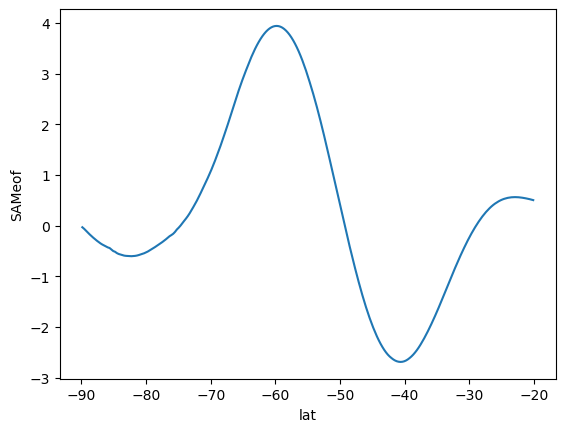

In [6]:
ds_sam['SAMeof'].plot()

In [7]:
mem_before = def_memory()
print('Memory before we load data: ', mem_before,'MB')

Memory before we load data:  225.0 MB


### To read in sfc wind stress variable

In [8]:
#ds= xr.open_dataset("saved_on_disk.nc")
indir='/scratch/b/b382037/ERA5_metss/' 

#for year in range(1940,1950):
#    inputfile = indir+'ERA5_500hPa_geop_1D_'+str(year)+'_regular.nc'
#    ds= xr.open_mfdataset(inputfile)
#ERA5_metss_GB_1980_03_DailyMean_regrid.nc
#ERA5_metss_GB_1980_03.nc
#ERA5_metss_SH_2023_09_DailyMean_regid.nc
ds_metss = xr.open_mfdataset(''+indir+'ERA5_metss_SH_*_DailyMean_regid.nc', concat_dim="valid_time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override')


OSError: no files to open

In [8]:
ds_metss

<xarray.Dataset>
Dimensions:          (valid_time: 16071, bnds: 2, lon: 1280, lat: 320)
Coordinates:
  * valid_time       (valid_time) datetime64[ns] 1980-01-01T11:30:00 ... 2023...
  * lon              (lon) float64 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * lat              (lat) float64 -89.86 -89.58 -89.3 ... -0.4219 -0.1406
Dimensions without coordinates: bnds
Data variables:
    valid_time_bnds  (valid_time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    metss            (valid_time, lat, lon) float32 dask.array<chunksize=(1, 1, 1280), meta=np.ndarray>
Attributes:
    CDI:                     Climate Data Interface version 2.2.4 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Tue Dec 17 14:25:27 2024: cdo remapbil,/work/bk1...
    frequency:               day
    CDO:                     Climate Data Operators version 2.2.2 (https://mp...

In [9]:
condition_reg = (ds_metss['lat'] > -90) & (ds_metss['lat'] <= -20)
# Apply the condition to select data within the latitude range
computed_condition_reg = condition_reg.compute()
ds_metss = ds_metss.where(computed_condition_reg, drop=True)

In [10]:
ds_metss

<xarray.Dataset>
Dimensions:          (valid_time: 16071, bnds: 2, lat: 249, lon: 1280)
Coordinates:
  * valid_time       (valid_time) datetime64[ns] 1980-01-01T11:30:00 ... 2023...
  * lon              (lon) float64 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * lat              (lat) float64 -89.86 -89.58 -89.3 ... -20.67 -20.39 -20.11
Dimensions without coordinates: bnds
Data variables:
    valid_time_bnds  (valid_time, bnds, lat) datetime64[ns] dask.array<chunksize=(1, 2, 249), meta=np.ndarray>
    metss            (valid_time, lat, lon) float32 dask.array<chunksize=(1, 1, 1280), meta=np.ndarray>
Attributes:
    CDI:                     Climate Data Interface version 2.2.4 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Tue Dec 17 14:25:27 2024: cdo remapbil,/work/bk1...
    frequency:               day
    CDO:                     Climate Data Operators version 2.2.2 (https://mp...

ds_metss['metss'].isel(valid_time=60).plot()

In [11]:
# To zonal averaging first
#uaz = monthly_means.mean(dim="lon", skipna=True)
metssz = ds_metss.mean(dim="lon", skipna=True)

In [12]:
a=6371*1.e3 #meter

In [13]:
wgts_diag=np.diag(coslat)
print(wgts_diag.shape)

(249, 249)


In [14]:
EOF1_u=ds_sam['SAMeof'].to_numpy()

In [15]:
denom = np.sqrt(np.matmul(np.matmul(EOF1_u,wgts_diag),EOF1_u.T))
print(denom)

22.266869399886428


In [16]:
We=np.matmul(wgts_diag, EOF1_u.T)
print(We.shape)
print(metssz['metss'].shape)

(249,)
(16071, 249)


In [17]:
coords_lat= {"lat":metssz['metss'].coords['lat'],}

We_xrarray = xr.DataArray(We.flatten(), dims=["lat"], coords= coords_lat)


In [18]:
metssz_sam = xr.dot(metssz['metss'], We_xrarray, dims="lat")/denom

In [19]:
metssz_sam

<xarray.DataArray (valid_time: 16071)>
dask.array<truediv, shape=(16071,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 1980-01-01T11:30:00 ... 2023-12-3...

In [20]:
metssz_sam = metssz_sam.chunk({'valid_time': 16071})

metssz_sam.values

metssz_sam.plot()

In [21]:
windstressterms = metssz_sam.to_dataset(name='uwindstress_sam')

In [22]:
outputFileName1 = 'ERA5_SAMsfcwindstress_1980_2023.nc'

print ('saving to ', outputFileName1)
windstressterms.to_netcdf(path=outputFileName1)
print ('finished saving')

saving to  ERA5_SAMsfcwindstress_1980_2023.nc
finished saving
